In [1]:
import random                                                                                      
import time                                                                                        
import datetime as dt                                                                              
import pandas as pd                                                                                                                                                     #
import numpy as np                                                                                 
import matplotlib.pyplot as plt                                                                    
import math                                                                                        
import matplotlib.pyplot as plt                                                                    
from keras.models import Sequential                                                                
from keras.layers import LSTM, Embedding, Dense, Dropout, RepeatVector, TimeDistributed            
from keras.optimizers import Adam                                                                  
from sklearn.preprocessing import MinMaxScaler                                                     
from sklearn.metrics import mean_squared_error    

In [3]:
file_path = r"f.xlsx"
df = pd.read_excel(file_path, index_col = 'date')
dataset= np.array(df[["4. close"]])
dataset


array([[ 38.2318],
       [ 34.03  ],
       [ 31.    ],
       ...,
       [254.75  ],
       [249.02  ],
       [249.53  ]])

In [4]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [5]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 6
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [6]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
model = Sequential()
model.add(LSTM(60, input_shape=(1, look_back),return_sequences=True))
model.add(LSTM(60, activation='relu',return_sequences=False))
model.add(Dropout(0.25))
model.add(Dense(1))
model.compile(Adam(0.001),loss='mean_squared_error')
h = model.fit(trainX, trainY, epochs=10, batch_size=3, verbose=2, validation_split = 0.05)

Epoch 1/10
530/530 - 3s - loss: 0.0099 - val_loss: 0.0029
Epoch 2/10
530/530 - 1s - loss: 0.0019 - val_loss: 2.9395e-04
Epoch 3/10
530/530 - 1s - loss: 0.0017 - val_loss: 2.8799e-04
Epoch 4/10
530/530 - 1s - loss: 0.0017 - val_loss: 3.9730e-04
Epoch 5/10
530/530 - 1s - loss: 0.0014 - val_loss: 0.0035
Epoch 6/10
530/530 - 1s - loss: 0.0012 - val_loss: 2.6183e-04
Epoch 7/10
530/530 - 1s - loss: 0.0012 - val_loss: 2.5092e-04
Epoch 8/10
530/530 - 1s - loss: 0.0011 - val_loss: 3.5339e-04
Epoch 9/10
530/530 - 1s - loss: 0.0012 - val_loss: 4.9245e-04
Epoch 10/10
530/530 - 1s - loss: 0.0011 - val_loss: 2.8837e-04


In [7]:
# make predictions
print("trainX shape = ", trainX.shape)
print("testX  shape = ", testX.shape)
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


trainX shape =  (1674, 1, 6)
testX  shape =  (414, 1, 6)
Train Score: 3.94 RMSE
Test Score: 9.38 RMSE


In [8]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
print("Real Data")
print(np.array(df[["4. close"]][-20:]))

print("Prediction")
print(testPredictPlot[-20:])

Real Data
[[293.22]
 [293.66]
 [293.2 ]
 [295.44]
 [302.5 ]
 [291.12]
 [282.73]
 [271.16]
 [273.72]
 [268.09]
 [266.61]
 [266.15]
 [272.42]
 [263.52]
 [254.82]
 [252.53]
 [248.15]
 [254.75]
 [249.02]
 [249.53]]
Prediction
[[299.37957764]
 [305.33740234]
 [309.4006958 ]
 [313.09036255]
 [317.09545898]
 [321.6763916 ]
 [318.7862854 ]
 [315.0090332 ]
 [308.27758789]
 [303.91955566]
 [298.34036255]
 [292.08364868]
 [287.79653931]
 [287.0874939 ]
 [285.12927246]
 [280.33468628]
 [276.33123779]
 [272.10140991]
 [270.67556763]
 [         nan]]


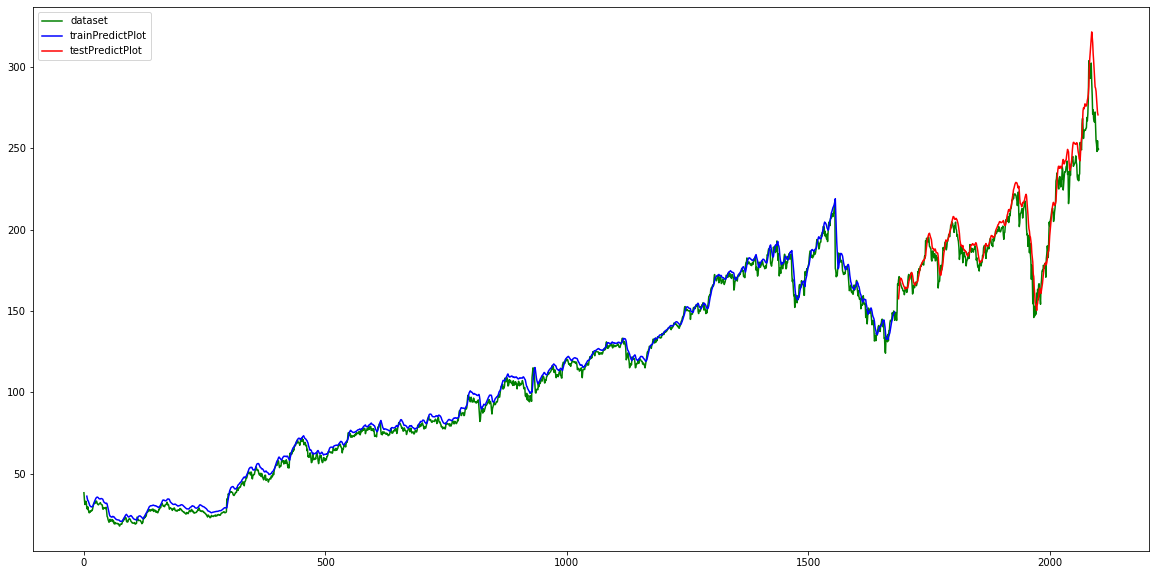

In [9]:
# plot baseline and predictions
plt.figure(figsize = (20,10))
plt.plot(scaler.inverse_transform(dataset), "g-")
plt.plot(trainPredictPlot, "b")
plt.plot(testPredictPlot, "r")
plt.legend(["dataset", "trainPredictPlot", "testPredictPlot"])
plt.show()